## Lung Cancer Detection using Convolutional Neural Network

CNN's process data with grid-like topology, being the de-facto model for computer vision and image processing classification problems.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image # python imaging library
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

2025-06-16 01:02:01.829223: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 01:02:01.914960: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-16 01:02:02.000875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750050122.075885     989 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750050122.097038     989 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750050122.263708     989 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Understanding the Dataset
Lung Colon Image Dataset contains over 25,000 histopathological images (images examined under a microscope).

Each image is 768x768 pixels in jpeg format.

There are five classifications for the dataset (only the first three are used in this project):
1. Lung benign tissue
2. Lung adenocarcinoma
3. Lung sqaumous cell carcinoma
4. Colon adencarcinoma
5. Colon bengin tissue

Each classifcation contains 5,000 images. 

In [2]:
LUNG_CLASSES = [
    'lung_n',
    'lung_aca',
    'lung_scc'
]

# not currently used
COLON_CLASSES = [
    'colon_aca',
    'colon_n'
]


In [ ]:
# extracts ./dataset

path_to_data = "./dataset/lung-and-colon-cancer-histopathological-images.zip"

with ZipFile(path_to_data, 'r') as zip:
    zip.extractall()
    


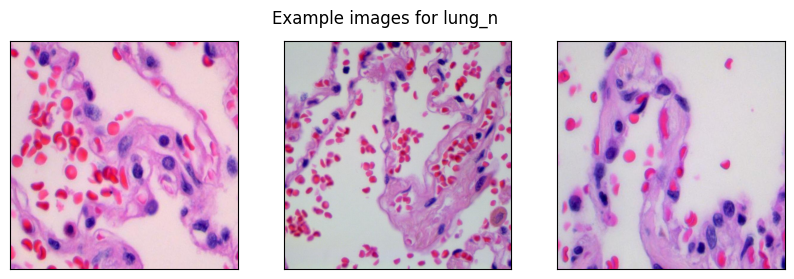

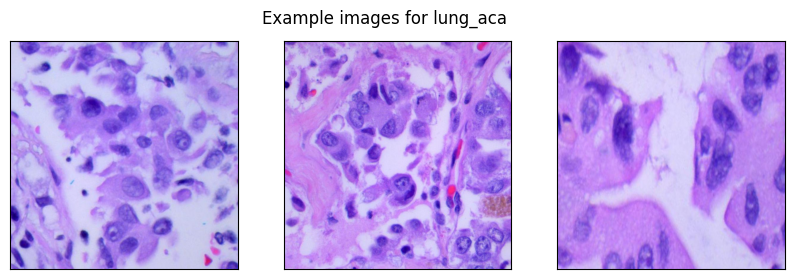

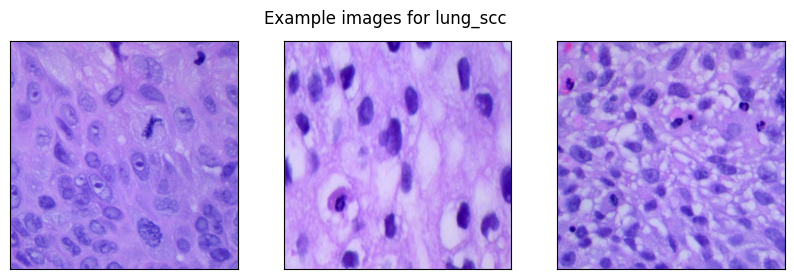

In [ ]:
# this block gets three random images from each of our image tissue types

for c in LUNG_CLASSES:
    image_path = f'.\lung_colon_image_set\lung_image_sets\{c}'
    all_images = os.listdir(image_path)
    
    
    fig, ax = plt.subplots( nrows=1 , ncols=3 , figsize=(10, 3))
    fig.suptitle(f"Example images for {c}")
    
    # get random images from each class
    for i in range(len(LUNG_CLASSES)):
        
        rand = np.random.randint(0, len(all_images))
        
        random_image = np.array(Image.open(f'.\{image_path}\{all_images[rand]}'))
        
        
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        
        
        ax[i].imshow(random_image)
        
        
    plt.show()
        
        
        

# Preprocessing 

- Resize each of the images to 256x256 in a numpy array. This improves the performance of the model.
- Encode the categorical labels for each image into a binary format using One Hot Encoding. This allows the label to be compatable with CNN. 
- Split the data at 80% and 20% for Training and Testing sets respectively. The test set will later be used to evaulate model performance.


In [3]:
# this block resizes each image in the image set and creates our X and Y datasets

PATH_TO_IMAGES = f'./lung_colon_image_set'


IMG_RESIZE = 256
SPLIT = 0.2

X = []
Y = []


for i, c in enumerate(LUNG_CLASSES):
    image_path = f'./lung_colon_image_set/lung_image_sets/{c}'
    all_images = os.listdir(image_path)
    
    for image in all_images:
        
        img = Image.open(image_path+'/'+image, mode='r')
        X.append( img.resize( ( IMG_RESIZE, IMG_RESIZE ) ) )
        Y.append( i )
        
        #img.show() # make sure it resizes correctly


In [4]:
# this code splits the dataset into a training and testing set

X = np.asarray(X)
OHE_Y = pd.get_dummies(Y).values

X_train, X_test, Y_train, Y_test = train_test_split(
    X, OHE_Y, test_size=SPLIT, random_state=123
)

# CNN Model Architecture
- Conv2D is a 2D convolutional layer which extracts features (colors, edges, shapes, etc.) by applying a filter (kernel) over the input image, it is common practice to use a kernal size of 3x3 or 5x5. This process produces a feature map: a layer which represents specific features in the input image.
- MaxPooling2D downsamples the feature map, reducing the dimensionality but sustaining the relevant features. This improves the overall performance of the model.
- ReLU is an activation function that maps negative values to 0 and positive values remain the same: max(0, x). ReLU is used largely for performance and to avoid vanishing gradient.
- Flatten flattens the 2D layer into a 1D vector.
- Dense layers prepare the data for classification.
- Batch Normalization normalizes (mean=0, std=1) the output of the layer before it.
- Dropout randomly sets inputs to 0, this prevents overfitting the model.
- Softmax helps convert the final layer of outputs to probabilities, which facilitates classification.

In [11]:
model = keras.Sequential([
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(3, activation='softmax')
])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Model Compilation

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)


# Training

In [14]:

history = model.fit(
  X_train, Y_train, 
  validation_data = (X_test, Y_test),
  epochs=1, 
  callbacks = [early_stopping]
)

375/375 ━━━━━━━━━━━━━━━━━━━━ 549s 1s/step - accuracy: 0.8643 - loss: 0.3419 - val_accuracy: 0.8370 - val_loss: 0.6224


In [31]:

model.save('saved_model/my_model.keras')

In [5]:
# use this cell to quickly load a model
model = tf.keras.models.load_model("saved_model/model.keras")

E0000 00:00:1750050290.474733     989 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1750050290.482777     989 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
Y_pred = model.predict(X_test)
Y_val = np.argmax(Y_test, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=LUNG_CLASSES))

2025-06-16 01:05:05.177668: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 483852288 exceeds 10% of free system memory.


77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step
              precision    recall  f1-score   support

      lung_n       0.99      0.95      0.97      1026
    lung_aca       0.68      0.99      0.81       995
    lung_scc       1.00      0.06      0.11       440

    accuracy                           0.81      2461
   macro avg       0.89      0.67      0.63      2461
weighted avg       0.87      0.81      0.75      2461

